In [1]:
code_dir = "../UXO_protected/+BTInvertPY"
import sys
sys.path.append(code_dir)

In [2]:
from BTSensor import SensorInfo, Model, preCalcLoopCorners, FModParam, forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
from BTInvert import getSettings, validate_std, signal2Noise, invert_single, invertML
import numpy as np
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize

In [3]:
from matplotlib import rcParams
rcParams["font.size"]=14

In [4]:
data_directory = "../UXO_protected/data-blacktusk"

In [5]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [6]:
# Load the data file and read all data into a dictionary
# dfile = os.path.join('.','matlab','d190723_BlossomPointPOS_inv.h5')
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()
 
icell = '1'
iinv = '1' # it is common for the 1st inversion result to be 1-obj, 2nd: 2-obj and so on

In [7]:
dic.keys()

dict_keys(['CELLChannels', 'SensorConfig', 'SensorName', 'CELL', 'CELLInfo', 'SensorTimes', 'XYZ'])

In [8]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [9]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
# tx_comp = int(xyz_dict["Info"]["TxComp"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [10]:
xyz_data = xyz_dict["Data"]

# get a sense of the survey geometry

Text(0.5, 1.0, 'Test-plot \n data locations')

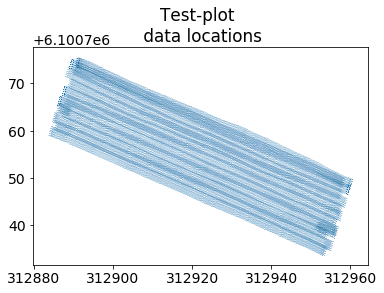

In [11]:
plt.plot(xyz_data[easting, :], xyz_data[northing, :], '.', alpha=0.1, ms=0.1);
plt.title("Test-plot \n data locations")

In [12]:
# plot a single measurement number
mn = xyz_data[mni, :].astype(int) - 1
print(mn.min(), mn.max())

0 164


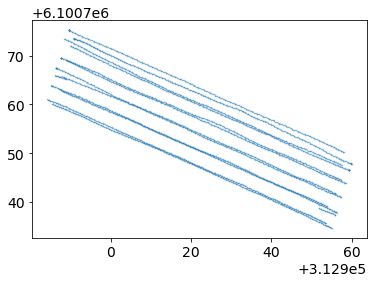

In [13]:
for plot_mn in range(1):
# plot_mn = 6
    inds = mn == plot_mn

    plt.plot(xyz_data[easting, inds], xyz_data[northing, inds], '.', alpha=0.5, ms=1)

In [14]:
lines = xyz_data[linesi, :].astype(int)
print(lines.min(), lines.max(), len(np.unique(lines)))

1001 1014 14


In [15]:
np.unique(lines)
x0 = np.r_[xyz_data[easting, :].min(), xyz_data[northing, :].min()]
print(x0)

[ 312883.62003853 6100733.69441273]


In [16]:
line_inds = lines == lines.min()
mn_inds = mn == 0
inds = line_inds & mn_inds

line_eastings = xyz_data[easting, inds]
line_northings = xyz_data[northing, inds]

dx = np.hstack([np.r_[0], np.diff(line_eastings)])
dy = np.hstack([np.r_[0], np.diff(line_northings)])

line_dl = np.sqrt(dx**2 + dy**2)
line_distances = np.cumsum(line_dl)

print(np.mean(line_dl))

0.21284075248176457


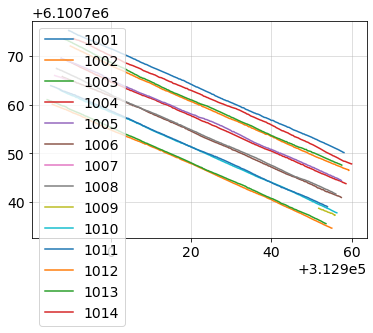

In [17]:
# line separations
line0 = lines == lines.min()
line1 = lines == lines.min() + 1
mn_inds = mn == 0

fig, ax = plt.subplots(1, 1)
for l in np.unique(lines):
    inds = mn_inds & (lines == l)
    line_eastings = xyz_data[easting, inds]
    line_northings = xyz_data[northing, inds]

    ax.plot(line_eastings, line_northings, label=l)
ax.grid(which="both", alpha=0.5)
ax.legend()
# ax.set_xlim(x0[0] + np.r_[10, 20])
# ax.set_ylim(x0[1] + np.r_[20, 40])

In [18]:
xyz_data[rx_num, :]

array([ 1.,  1.,  1., ..., 11., 11., 11.])

0
1
2
3
4


(6100771.94441273, 6100772.19441273)

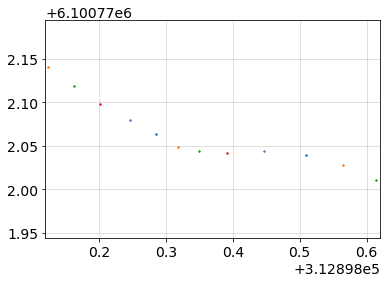

In [19]:
# how far apart are transmitter firings?
rx_inds = xyz_data[rx_num, :].astype(int) == 1
inds = rx_inds & (lines == lines.min())

fig, ax = plt.subplots(1, 1)

for i in range(5):
    print(i)
    indstx1 = inds & (xyz_data[tx_num,:].astype(int) == i+1)
    line_eastings = xyz_data[easting, indstx1]
    line_northings = xyz_data[northing, indstx1]
    ax.plot(line_eastings, line_northings, '.', ms=2)
ax.grid(which="both", alpha=0.5)
ax.set_xlim(x0[0] + np.r_[14.5, 15])
ax.set_ylim(x0[1] + np.r_[38.25, 38.5])

# plot some data

In [20]:
print(len(datai), len(times))

27 27


In [21]:
def along_line_distance(line_eastings, line_northings):
    dx = np.hstack([np.r_[0], np.diff(line_eastings)])
    dy = np.hstack([np.r_[0], np.diff(line_northings)])

    line_dl = np.sqrt(dx**2 + dy**2)
    line_distances = np.cumsum(line_dl)
    return line_distances

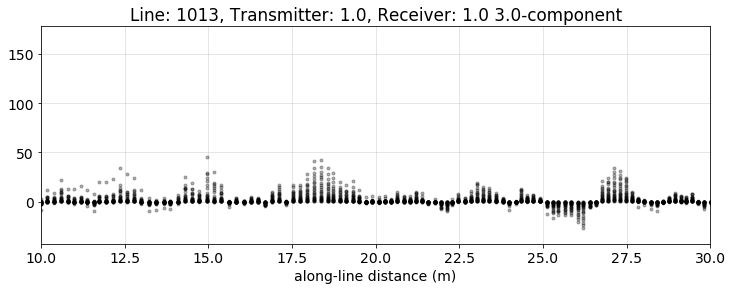

In [22]:
line_id = 1013
line_inds = lines == line_id
mn_inds = mn == 0
inds = line_inds & mn_inds

line_distances = along_line_distance(xyz_data[easting, inds], xyz_data[northing, inds])

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for t, dind in zip(times, datai):
    ax.plot(line_distances, xyz_data[dind, inds], '.', color="k", alpha=0.3)
    
txnumplot = np.unique(xyz_data[tx_num, inds])[0]
rxnumplot = np.unique(xyz_data[rx_num, inds])[0]
rxcompplot = np.unique(xyz_data[rx_comp, inds])[0]
ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot} {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

ax.set_xlim([10, 30])
ax.grid(which="both", alpha=0.4)
    

In [23]:
xyz_data[rx_comp, :]

array([1., 2., 3., ..., 1., 2., 3.])

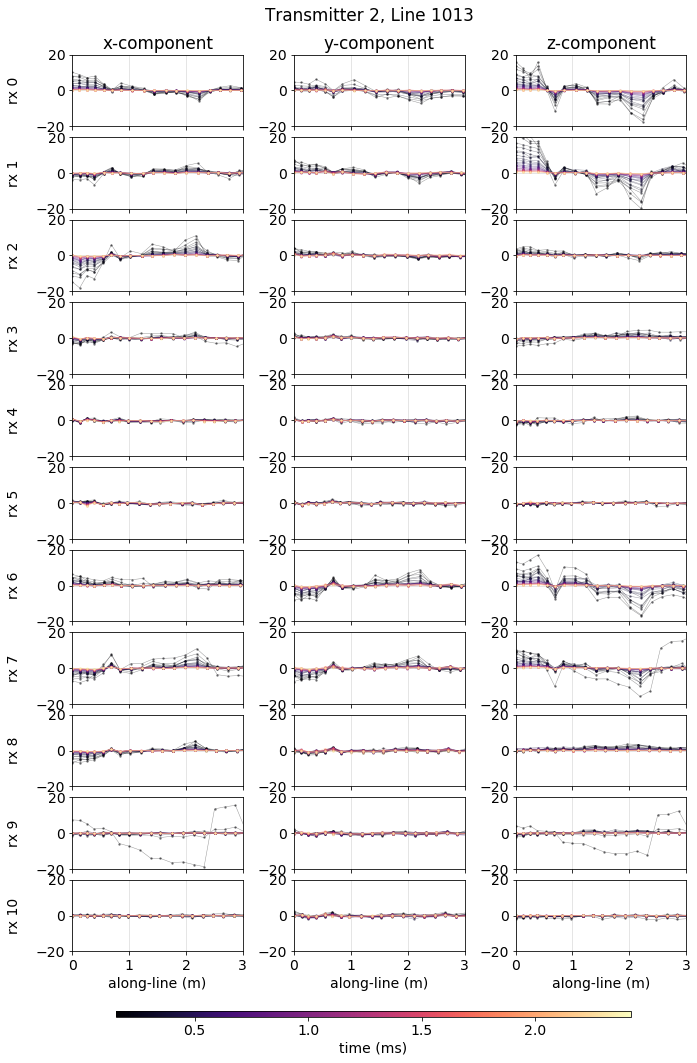

In [24]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])



line_id = 1013
plot_tx = 1
line_inds = lines == line_id
tx_inds = xyz_data[tx_num, :] == plot_tx
inds = line_inds & tx_inds

line_eastings = xyz_data[easting, inds]
line_northings = xyz_data[northing, inds]

xlim = np.r_[0, 3]

for rx in range(nrx):
    ii = inds & (xyz_data[rx_num] == rx+1)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        iii = ii & (xyz_data[rx_comp, :] == comp+1)
        line_distances = along_line_distance(xyz_data[easting, iii], xyz_data[northing, iii])
        
        for t, dind in enumerate(datai):
            a.plot(
                line_distances, xyz_data[dind, :][iii], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        
        if xlim is not None:
            a.set_xlim(xlim)
            a.set_ylim([-20, 20])
        
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Line {line_id}", y=0.92);


In [25]:
os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"])

'../UXO_protected/data-blacktusk/groundtruth_Testplot5F.xlsx'

In [26]:
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [27]:
groundtruth

,Easting,Northing,Item number,Comment,ItemBuried,Depth (m),Orientation,longitude,latitude,Planned Seed,Metal,EstAccuracy,PDOP,HDOP,Photo
0,312923.525000,6.100749e+06,1,1_20mmBolt_0.15_Ha,20mm,0.15,Axial,138.944544,-35.218871,1_20mmBolt_0.15_Ha,1,0.7,1.3,0.6,images/insphere/8b4ae8cd-a2bb-4855-87cf-f85558...
1,312926.298536,6.100748e+06,2,2_20mmBolt_0.15_Hx,20mm,0.15,Cross track,138.944574,-35.218882,2_20mmBolt_0.15_Hx,1,0.7,1.3,0.6,images/insphere/a4d2680a-e5d2-4c6b-9888-769547...
2,312929.203975,6.100747e+06,3,3_20mmBolt_0.15_V,20mm,0.15,Vertical,138.944606,-35.218891,3_20mmBolt_0.15_V,1,0.7,1.3,0.6,images/insphere/eb8255ca-f81a-471d-9f86-53d24d...
3,312932.060743,6.100746e+06,4,4_20mmBolt_0.25_Ha,20mm,0.25,Axial,138.944637,-35.218902,4_20mmBolt_0.25_Ha,1,0.8,1.3,0.6,images/insphere/d47305f2-f589-4872-a479-efad87...
4,312934.742422,6.100745e+06,5,5_20mmBolt_0.25_Hx,20mm,0.25,Cross track,138.944667,-35.218912,5_20mmBolt_0.25_Hx,1,0.9,1.3,0.6,images/insphere/9e02c7b7-7a4c-4e54-9371-9a8f7f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,312912.616620,6.100753e+06,93,Tail fin frag 21cm from 53 sml iso,EOD9160,0.30,Vertical,138.944425,-35.218832,NaN,1,1.4,1.8,0.9,images/insphere/ec94e523-5116-4936-ad36-cbceb2...
89,312939.007478,6.100754e+06,57,Cardinal point marker 5m from sml ISO,North 5m,0.00,NaN,138.944715,-35.218827,NaN,0,1.1,1.7,0.7,images/insphere/ccf88b9f-cf87-4411-8b39-ddbe3d...
90,312938.995607,6.100744e+06,58,Cardinal point marker 5m from sml ISO,South 5m,0.00,NaN,138.944713,-35.218918,NaN,0,1.1,1.7,0.7,images/insphere/ae074ca8-fa04-4136-8518-abf874...
91,312944.014303,6.100749e+06,59,Cardinal point marker 5m from sml ISO,East 5m,0.00,NaN,138.944769,-35.218874,NaN,0,1.1,1.6,0.7,images/insphere/36cbea37-d11b-4d72-bf1c-824741...


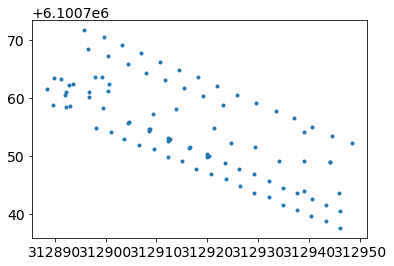

In [28]:
plt.plot(groundtruth[["Easting"]], groundtruth[["Northing"]], '.')

//miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


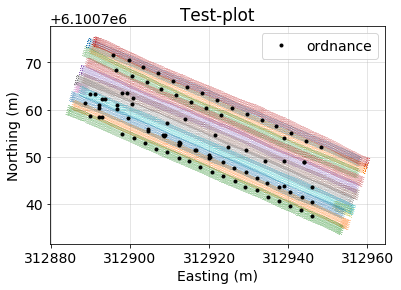

In [29]:
fig, ax = plt.subplots(1, 1)

for l in np.unique(xyz_data[linesi]):
    inds = xyz_data[linesi] == l
    ax.plot(xyz_data[easting, inds], xyz_data[northing, inds], '.', alpha=0.1, ms=0.1);

ax.plot(groundtruth[["Easting"]], groundtruth[["Northing"]], 'k.', label="ordnance")
ax.legend()
ax.set_title("Test-plot")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid("both", alpha=0.4)

# rotate the data sets

In [30]:
from scipy import stats

In [31]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

In [32]:
slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [33]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


(0, 10)

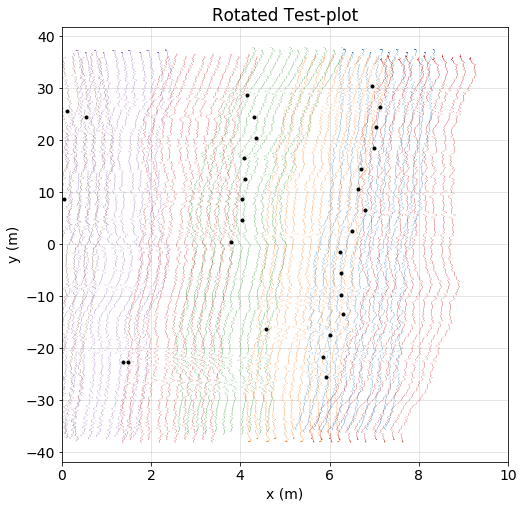

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for l in np.unique(xyz_data[linesi]):
    inds = xyz_data[linesi] == l
    ax.plot(local_x[inds], local_y[inds], '.', alpha=0.1, ms=0.2);

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")
# ax.legend()
ax.set_title("Rotated Test-plot")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid("both", alpha=0.4)
ax.set_xlim([0, 10])

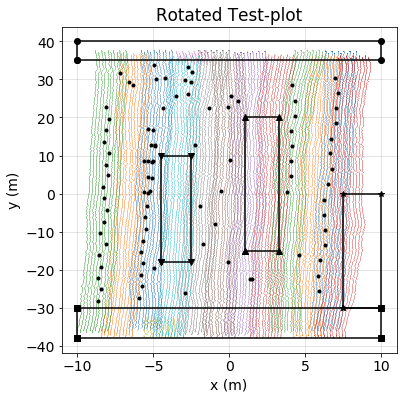

In [36]:
# grab a subset of data without ordnance to get a sense of noise statistics
patches_x = [
    np.r_[-10, 10],
    np.r_[-10, 10],
    np.r_[-4.5, -2.5], 
    np.r_[1, 3.25],
    np.r_[7.5, 10],
]

patches_y = [
    np.r_[35, 40],
    np.r_[-38, -30],
    np.r_[-18, 10],
    np.r_[-15, 20],
    np.r_[-30, 0],
]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for l in np.unique(xyz_data[linesi]):
    inds = xyz_data[linesi] == l
    ax.plot(local_x[inds], local_y[inds], '.', alpha=0.1, ms=0.2);

for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):

    plotting_x = np.r_[
        patch_x[0], patch_x[0], patch_x[1], patch_x[1], patch_x[0]
    ]

    plotting_y = np.r_[
        patch_y[0], patch_y[1], patch_y[1], patch_y[0], patch_y[0]
    ]
    
    ax.plot(plotting_x, plotting_y, "k", marker=marker)

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

# ax.legend()
ax.set_title("Rotated Test-plot")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid("both", alpha=0.4)
# ax.set_xlim([0, 10])

Text(0, 0.5, 'amplitdue')

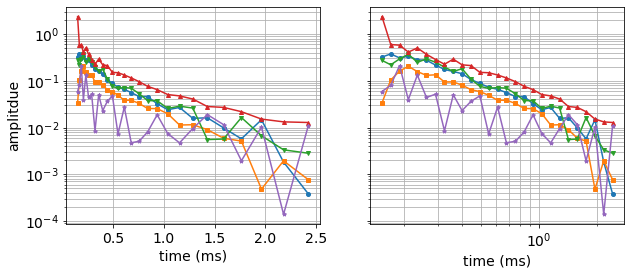

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):
    patch_inds = (
        (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
        (local_y >= patch_y.min()) & (local_y <= patch_y.max())
    )
    data_patch = xyz_data[datai, :][:, patch_inds]
    for a, plot_type in zip(ax, ["semilogy", "loglog"]):
        getattr(a, plot_type)(times, np.abs(np.mean(data_patch, 1)), marker=marker, ms=4)

for a in ax: 
    a.grid(which="both")
    a.set_xlabel("time (ms)")
    
ax[0].set_ylabel("amplitdue")

Text(0, 0.5, 'amplitdue')

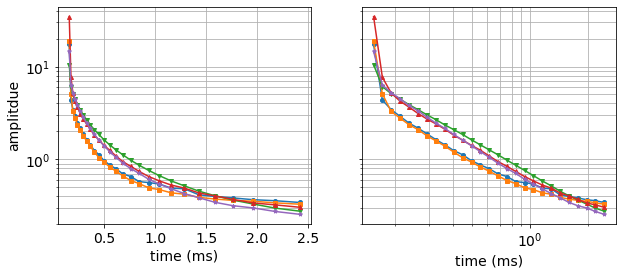

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):
    patch_inds = (
        (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
        (local_y >= patch_y.min()) & (local_y <= patch_y.max())
    )
    data_patch = xyz_data[datai, :][:, patch_inds]
    for a, plot_type in zip(ax, ["semilogy", "loglog"]):
        getattr(a, plot_type)(times, np.std(data_patch, 1), marker=marker, ms=4)

for a in ax: 
    a.grid(which="both")
    a.set_xlabel("time (ms)")
    
ax[0].set_ylabel("amplitdue")



In [38]:
slopes = []
intercepts = []

for patch_x, patch_y in zip(patches_x, patches_y):
    patch_inds = (
        (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
        (local_y >= patch_y.min()) & (local_y <= patch_y.max())
    )
    data_patch = xyz_data[datai, :][:, patch_inds]
    slope, intercept, _, _, _ = stats.linregress(np.log(times), np.log(np.std(data_patch, 1)))
    
    slopes.append(slope)
    intercepts.append(intercept)
    print(slope, intercept)
    

-1.0554667576705397 -0.5243199382014494
-1.0935482667061345 -0.5930227788151107
-1.2121797529304346 -0.33726196693259536
-1.294814107699712 -0.3969164136741159
-1.2980575704204602 -0.4831839879092278


In [43]:
np.mean(slopes, intercepts)

-0.4669410171064999

In [39]:
def noise_model(times, slope=-1, intercept=-0.5):
    return np.exp(slope * np.log(times) + intercept)

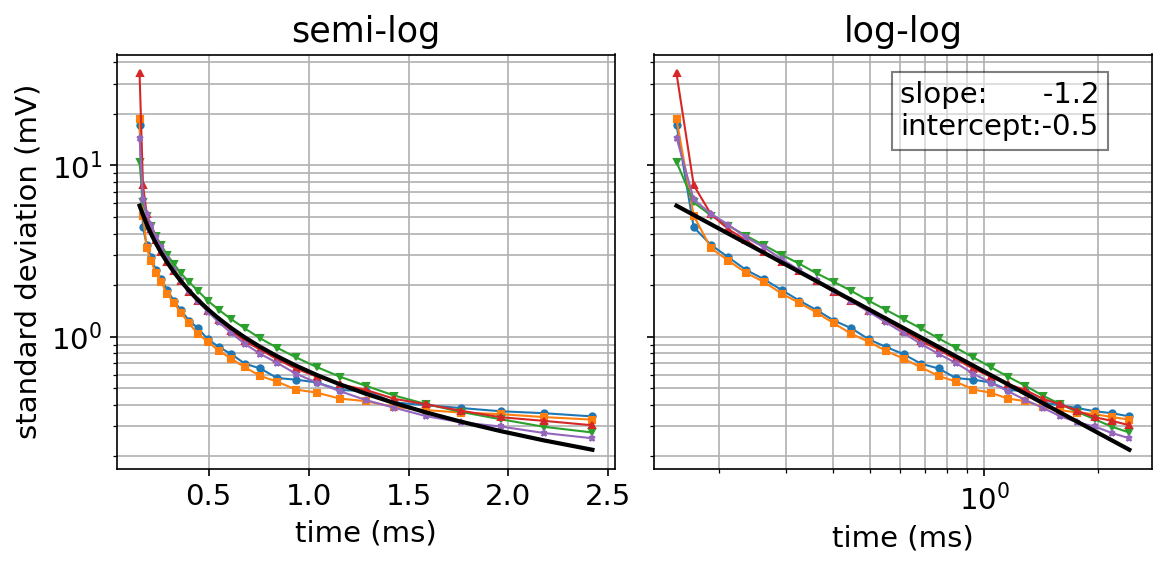

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, dpi=150)

slope = np.mean(slopes)
intercept = np.mean(intercepts)

plot_types = ["semilogy", "loglog"]

for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):
    patch_inds = (
        (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
        (local_y >= patch_y.min()) & (local_y <= patch_y.max())
    )
    data_patch = xyz_data[datai, :][:, patch_inds]
    for a, plot_type in zip(ax, plot_types):
        getattr(a, plot_type)(times, np.std(data_patch, 1), marker=marker, ms=3, lw=1)

for a, plot_type in zip(ax, plot_types): 
    a.grid(which="both")
    a.set_xlabel("time (ms)")
    getattr(a, plot_type)(times, noise_model(times, slope=slope, intercept=intercept), "k", lw=2)
    
ax[1].text(
    0.6, 1.5e1,
    f"slope:      {slope:1.1f}\n"
    f"intercept:{intercept:1.1f}", 
    bbox=dict(facecolor='w', alpha=0.5, edgecolor="k")
)    

ax[0].set_title("semi-log")
ax[1].set_title("log-log")
ax[0].set_ylabel("standard deviation (mV)")
plt.tight_layout()

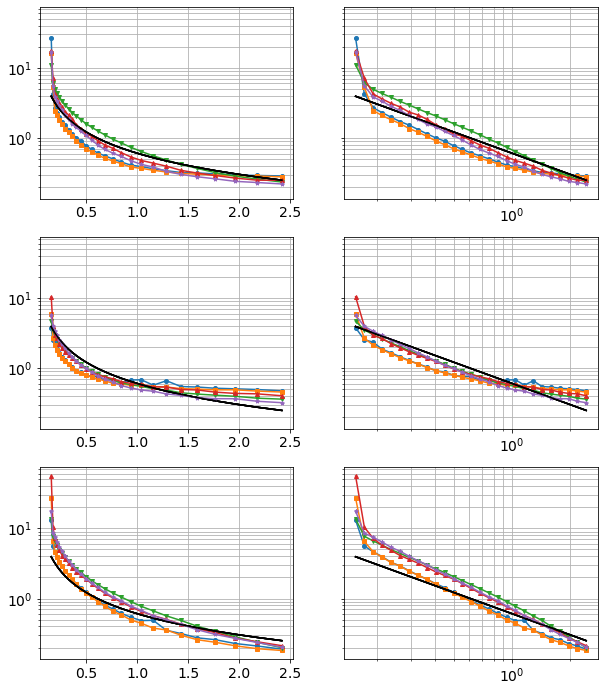

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharey=True)

for i in range(3):
    for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):
        patch_inds = (
            (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
            (local_y >= patch_y.min()) & (local_y <= patch_y.max())
        ) & (xyz_data[rx_comp] == i+1)


        data_patch = xyz_data[datai, :][:, patch_inds]
        for a, plot_type in zip(ax[i, :], ["semilogy", "loglog"]):
            getattr(a, plot_type)(times, np.std(data_patch, 1), marker=marker, ms=4)
            getattr(a, plot_type)(times, noise_model(times), "k")

for a in ax.flatten(): 
    a.grid(which="both")
    
#     a.set_xlabel("time (ms)")
    
# ax[0].set_ylabel("amplitdue")

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12), sharey=True)

for i in range(5):
    for patch_x, patch_y, marker in zip(patches_x, patches_y, ["o", "s", "v", "^", "*"]):
        patch_inds = (
            (local_x >= patch_x.min()) & (local_x <= patch_x.max()) & 
            (local_y >= patch_y.min()) & (local_y <= patch_y.max())
        ) & (xyz_data[tx_num] == i+1)


        data_patch = xyz_data[datai, :][:, patch_inds]
        for a, plot_type in zip(ax[i, :], ["semilogy", "loglog"]):
            getattr(a, plot_type)(times, np.std(data_patch, 1), marker=marker, ms=4)
            getattr(a, plot_type)(times, noise_model(times), "k")

for a in ax.flatten(): 
    a.grid(which="both")
    
#     a.set_xlabel("time (ms)")
    
# ax[0].set_ylabel("amplitdue")